In [2]:
import json
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from pandas.plotting import scatter_matrix
from tqdm import tqdm
import matplotlib.colors as mcolors
import seaborn as sns
import ta
%matplotlib inline

pd.set_option('display.max_columns', None)

<div style='font-size: 40px;'><u>Simulation</u></div>

In [3]:
def calculate_rsi(prices, period=14):
    """
    Calculate the Relative Strength Index (RSI) for a given time series array of stock prices.

    Args:
    - prices (list): A list of stock prices in chronological order.
    - period (int): The time period over which to calculate the RSI. Default is 14.

    Returns:
    - rsi_values (list): An array of RSI values corresponding to the input prices.
    """
    if len(prices) < period:
        raise ValueError("Length of prices array should be greater than or equal to the period.")

    delta = [prices[i + 1] - prices[i] for i in range(len(prices) - 1)]
    gain = [d if d > 0 else 0 for d in delta]
    loss = [abs(d) if d < 0 else 0 for d in delta]

    avg_gain = sum(gain[:period]) / period
    avg_loss = sum(loss[:period]) / period

    rsi_values = [None] * period

    rs = avg_gain / avg_loss if avg_loss != 0 else float('inf')
    rsi_values.append(100 - (100 / (1 + rs)))

    for i in range(period, len(prices) - 1):
        avg_gain = (avg_gain * (period - 1) + gain[i]) / period
        avg_loss = (avg_loss * (period - 1) + loss[i]) / period
        rs = avg_gain / avg_loss if avg_loss != 0 else float('inf')
        rsi_values.append(100 - (100 / (1 + rs)))

    return rsi_values

def calculate_adx(focus, window=14):
    """
    Calculate ADX (Average Directional Index) values for a given time series array of close prices.

    Args:
    close_prices (list or numpy array): Time series array of close prices.
    window (int): Window size for calculating ADX. Default is 14.

    Returns:
    adx_values (numpy array): Array of ADX values of the same length as input array.
    """
    # Initialize ADX indicator
    adx_indicator = ta.trend.ADXIndicator(high=focus['high'], low=focus['low'], close=focus['close'], window=window)

    # Calculate ADX values
    adx_values = adx_indicator.adx()

    return adx_values

def calculate_macd(close_prices):
    # Create a DataFrame with the close prices
    df = pd.DataFrame({'close': close_prices})
    
    # Calculate MACD using ta package
    df['macd'] = ta.trend.macd_diff(df['close'])
    
    # Extract MACD values
    macd_values = df['macd'].values
    
    return macd_values

def calculate_dmi(df: pd.DataFrame, period: int = 14) -> pd.DataFrame:
    """
    Calculate DI+, DI-, and DMI for a DataFrame with Open, High, Low, Close (OHLC) data.
    :param df: DataFrame containing 'High' and 'Low' price columns.
    :param period: Lookback period for calculation.
    :return: DataFrame with added DI+, DI-, and DMI columns.
    """
    high, low, close = df['high'], df['low'], df['close']
    
    # Calculate True Range Components
    up_move = high.diff()
    down_move = low.diff()
    
    # Compute +DM and -DM
    plus_dm = np.where((up_move > down_move) & (up_move > 0), up_move, 0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), abs(down_move), 0)
    
    # Compute TR (True Range)
    tr1 = high - low
    tr2 = abs(high - close.shift(1))
    tr3 = abs(low - close.shift(1))
    tr = np.maximum.reduce([tr1, tr2, tr3])
    
    # Smooth +DM, -DM, and TR using EMA
    smoothed_tr = pd.Series(tr).ewm(span=period, min_periods=period).mean()
    smoothed_plus_dm = pd.Series(plus_dm).ewm(span=period, min_periods=period).mean()
    smoothed_minus_dm = pd.Series(minus_dm).ewm(span=period, min_periods=period).mean()
    
    # Compute DI+ and DI-
    di_plus = 100 * (smoothed_plus_dm / smoothed_tr)
    di_minus = 100 * (smoothed_minus_dm / smoothed_tr)
    
    # Compute DMI (DX and ADX)
    dx = 100 * abs((di_plus - di_minus) / (di_plus + di_minus))
    adx = dx.ewm(span=period, min_periods=period).mean()
    
    # Append results to DataFrame
    df['DI+'] = di_plus
    df['DI-'] = di_minus
    df['DMI'] = adx
    
    return df


In [4]:
def load_stock(data, mean_period, std, rsi_threshold, adx_threshold, macd_threshold, di_plus_threshold):
    
    hist = data
    
    #n is the number of periods
    n=mean_period
    
    #SMA
    #hist['n_mean'] = [hist['close'][i-19:i+1].mean() for i in range(len(hist))]

    #EMA
    hist['n_mean'] = hist['close'].ewm(span=n, adjust=False).mean()
    
    #bollingers
        
    hist['n_std'] = [np.std(hist['close'][i-n+1:i+1]) for i in range(len(hist))]
    hist['n-BU'] = [hist['n_mean'].iloc[i] + std * hist['n_std'].iloc[i] for i in range(len(hist))]
    hist['n-BL'] = [hist['n_mean'].iloc[i] - std * hist['n_std'].iloc[i] for i in range(len(hist))]

    period = 14

    hist['RSI'] = calculate_rsi(np.array(hist['close']), period)
    hist['ADX'] = calculate_adx(hist, period)
    hist['MACD'] = calculate_macd(np.array(hist['close']))
    hist = calculate_dmi(hist, period)

    hist['3m_slope'] = [(hist['close'].iloc[i] - hist['close'].iloc[i-3])/3 for i in range(len(hist))]
    hist['5m_slope'] = [(hist['close'].iloc[i] - hist['close'].iloc[i-5])/5 for i in range(len(hist))]
    hist['10m_slope'] = [(hist['close'].iloc[i] - hist['close'].iloc[i-10])/10 for i in range(len(hist))]
    hist['20m_slope'] = [(hist['close'].iloc[i] - hist['close'].iloc[i-20])/20 for i in range(len(hist))]
    hist['30m_slope'] = [(hist['close'].iloc[i] - hist['close'].iloc[i-30])/30 for i in range(len(hist))]

    hist['roc'] = hist['close'].pct_change(periods=5)

    for lag in [1, 2, 3]:
        hist[f'RSI_lag{lag}'] = hist['RSI'].shift(lag)
        hist[f'MACD_lag{lag}'] = hist['MACD'].shift(lag)
        hist[f'ADX_lag{lag}'] = hist['ADX'].shift(lag)
        hist[f'DI+_lag{lag}'] = hist['DI+'].shift(lag)
        hist[f'DI__lag{lag}'] = hist['DI-'].shift(lag)

    
    #focus################
        #focus_start = '2024-03-04 09:30:00-05:00'
        #focus_end = '2024-03-12 16:00:00-05:00'
    focus = hist.copy()#loc[focus_start:focus_end].copy()
    
    focus.loc[:,'under'] = focus['close']<focus['n-BL']
    #focus.loc[:,'signal'] = [(focus['under'].iloc[i] == True) and (focus['under'].iloc[i-1] == False) for i in range(len(focus))]
    
    # Step 1: Compute the initial signal based on conditions
    focus['raw_signal'] = (
        (focus['under'] == True)
        # (focus['RSI'] < rsi_threshold) & 
        # (focus['ADX'] > adx_threshold) & 
        # (focus['MACD'] > macd_threshold) & 
        # (focus['DI+'] > di_plus_threshold)
    )

    def isolate_first_trues(raw_signal):
        signal = []
        prev = False
        for val in raw_signal:
            if val and not prev:
                signal.append(True)
            else:
                signal.append(False)
            prev = val
        return signal

    # Step 2: Get only the first value of any consecutive "True" bunches
    focus['signal'] = isolate_first_trues(focus['raw_signal'])

    #signals################
    signals = focus[focus['signal'] == 1]

    return hist, focus, signals

In [41]:
def simulate(focus, signals, sell_std = 0, loss_threshold = 0.98, sim_type = 1):

    maker_fee = 0.000
    taker_fee = 0.000
    spread = 0.0
    
    focus = focus.reset_index()
    signal_on = False
    growth = 1.0
    growth_vals = np.array([])
    growth_monetary_vals = np.array([])
    growth_times = []
    buy_price = 0
    sell_price = 0
    curr_buy_i = 0
    focus['green_buy'] = False
    focus['red_buy'] = False
    focus['green_sell'] = False
    focus['red_sell'] = False
    focus['REJECTED_BUY'] = False
    
    def open_order(i):
        signal_on = True
        buy_price = focus['close'].iloc[i]
        curr_buy_i = i
        return signal_on, buy_price, curr_buy_i
    
    def close_order(i, growth_vals, growth_monetary_vals, growth, growth_times):
        sell_price = focus['close'].iloc[i]
        ratio = (sell_price-spread)/buy_price - (maker_fee + taker_fee) - 1
        growth_vals = np.append(growth_vals, ratio)
        growth_monetary_vals = np.append(growth_monetary_vals, sell_price - buy_price - spread)
        growth = growth + ratio
        growth_times += [focus['timestamp'][i]]
        signal_on = False
        return signal_on, growth, growth_vals, growth_monetary_vals
        
    for i in range(len(focus)):

        if not signal_on:
            # Check original signal condition
            if focus['signal'].iloc[i] == True:
                if sim_type == 1:
                    signal_on, buy_price, curr_buy_i = open_order(i)
                elif sim_type == 2:
                    # Extract model input for this row
                    model_features = focus.loc[i, [
                        'n_std', 'RSI', 'ADX', 'MACD', 'DI+', 'DI-', 'DMI',
                        # '3m_slope', '5m_slope', '10m_slope', '20m_slope', '30m_slope',
                        'roc',  # Rate of Change
                        # 'RSI_lag1', 'RSI_lag2', 'RSI_lag3',  # Lagged features for RSI
                        # 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',  # Lagged features for MACD
                        # 'ADX_lag1', 'ADX_lag2', 'ADX_lag3',  # Lagged features for ADX
                    ]].values.reshape(1, -1)


                    # Make prediction using trained model
                    model_prediction = model.predict(model_features)[0]  # True or False

                    if model_prediction:
                        # Only open order if model agrees
                        signal_on, buy_price, curr_buy_i = open_order(i)   
                    else:
                        focus.at[i, 'REJECTED_BUY'] = True 
    
        elif signal_on == True:
            if focus['signal'].iloc[i] == True:
                signal_on, growth, growth_vals, growth_monetary_vals = close_order(i, growth_vals, growth_monetary_vals, growth, growth_times)
                if focus['close'].iloc[i] >= focus['n_mean'].iloc[i] + sell_std * focus['n_std'].iloc[i]:
                    focus.at[i, 'green_sell'] = True 
                    focus.at[curr_buy_i, 'green_buy'] = True
                    signal_on, buy_price, curr_buy_i = open_order(i)
                else:
                    focus.at[i, 'red_sell'] = True
                    focus.at[curr_buy_i, 'red_buy'] = True
                    signal_on, buy_price, curr_buy_i = open_order(i)

            elif focus['close'].iloc[i] >= focus['n_mean'].iloc[i] + sell_std * focus['n_std'].iloc[i]:
                signal_on, growth, growth_vals, growth_monetary_vals = close_order(i, growth_vals, growth_monetary_vals, growth, growth_times)
                if focus['close'].iloc[i] > buy_price:
                    focus.at[i, 'green_sell'] = True 
                    focus.at[curr_buy_i, 'green_buy'] = True 
                else:
                    focus.at[i, 'red_sell'] = True
                    focus.at[curr_buy_i, 'red_buy'] = True

            #risk mitigation; sell if drop more than n% from buy price
            elif focus['close'].iloc[i] < loss_threshold*buy_price:
                signal_on, growth, growth_vals, growth_monetary_vals = close_order(i, growth_vals, growth_monetary_vals, growth, growth_times)
                focus.at[i, 'red_sell'] = True
                focus.at[curr_buy_i, 'red_buy'] = True
                
            #elif focus.index.time == pd.Timestamp('15:59:00').time():
                #signal_on, growth, growth_vals = close_order(i, growth_vals, growth)
    
    focus = focus.set_index('timestamp')
    growth_progression = np.cumsum(growth_vals)

    
    #print('growth: ',(growth - 1)*100,'%')
    #print('growth mean: ',np.mean(growth_vals))
    #print('growth max: ',max(growth_vals))
    return growth, growth_vals, growth_monetary_vals, growth_progression, growth_times, focus

In [31]:
def plot_buy_and_sell(focus, sell_std):
    fig3 = go.Figure()

    # Prices
    fig3.add_trace(go.Scatter(
    x=focus.index, 
    y=focus['close'], 
    mode='lines', 
    name='Price', 
    line=dict(color='blue'),
    customdata=focus[['RSI', 'ADX', 'MACD', 'DI+', 'DI-']],  # Include DI-
    hovertemplate=(
        "Date: %{x}<br>Price: %{y}<br>"
        "RSI: %{customdata[0]}<br>"
        "ADX: %{customdata[1]}<br>"
        "MACD: %{customdata[2]}<br>"
        "DI+: %{customdata[3]}<br>"
        "DI-: %{customdata[4]}<extra></extra>"  # Add DI- here
    )
))

    # 20-day Mean
    fig3.add_trace(go.Scatter(
        x=focus.index, 
        y=focus['n_mean'], 
        mode='lines', 
        name='Mean', 
        line=dict(color='crimson')
    ))

    # # 20-day Bollinger Bands
    # fig3.add_trace(go.Scatter(
    #     x=focus.index, 
    #     y=focus['n-BU'], 
    #     mode='lines', 
    #     name='Bollinger Upper', 
    #     line=dict(color='goldenrod')
    # ))

    fig3.add_trace(go.Scatter(
        x=focus.index, 
        y=focus['n-BL'], 
        mode='lines', 
        name='Bollinger Lower', 
        line=dict(color='goldenrod')
    ))

    fig3.add_trace(go.Scatter(
        x=focus.index, 
        y=focus['n_mean'] + focus['n_std'] * sell_std, 
        mode='lines', 
        name='Exit Line', 
        line=dict(color='mediumpurple')
    ))

    # Helper function to add buy/sell markers with hover data
    def add_marker_trace(name, color, condition):
        fig3.add_trace(go.Scatter(
            x=focus.index[condition], 
            y=focus.loc[condition, 'close'], 
            mode='markers', 
            name=name, 
            marker=dict(color=color, size=8),
            customdata=focus[['RSI', 'ADX', 'MACD', 'DI+', 'DI-']],  # Include DI-
            hovertemplate=(
                "Date: %{x}<br>Price: %{y}<br>"
                "RSI: %{customdata[0]}<br>"
                "ADX: %{customdata[1]}<br>"
                "MACD: %{customdata[2]}<br>"
                "DI+: %{customdata[3]}<br>"
                "DI-: %{customdata[4]}<extra></extra>"  # Add DI- here
            )
        ))

    # Add Buy/Sell markers with custom hover data
    add_marker_trace('rejected', 'red', focus['REJECTED_BUY'].values)
    add_marker_trace('Red Buy', 'firebrick', focus['red_buy'].values)
    add_marker_trace('Red Sell', 'magenta', focus['red_sell'].values)
    add_marker_trace('Green Buy', 'forestgreen', focus['green_buy'].values)
    add_marker_trace('Green Sell', 'limegreen', focus['green_sell'].values)

    # Update layout
    fig3.update_layout(width=1200, height=650, title='Buy and Sell')
    
    # Show the plot
    fig3.show()


In [84]:
# Load Data
########################
ticker = 'AMD'
timeframe = '730'
data = pd.read_csv(f"hist_data/{ticker} - {timeframe} Day.csv")
data = data[300000:]
data

,timestamp,symbol,open,high,low,close,volume,trade_count,vwap
300000,2024-11-01 14:10:00+00:00,AMD,142.2600,142.4899,142.2000,142.4200,88910.0,1169.0,142.385113
300001,2024-11-01 14:11:00+00:00,AMD,142.4199,142.7000,142.3000,142.6700,113024.0,1338.0,142.499763
300002,2024-11-01 14:12:00+00:00,AMD,142.6800,142.9700,142.6100,142.9700,145201.0,1450.0,142.778438
300003,2024-11-01 14:13:00+00:00,AMD,142.9519,142.9700,142.8652,142.8999,97445.0,1153.0,142.930326
300004,2024-11-01 14:14:00+00:00,AMD,142.9200,142.9650,142.7600,142.8300,86721.0,1250.0,142.877651
...,...,...,...,...,...,...,...,...,...
386183,2025-04-08 23:55:00+00:00,AMD,76.0995,76.1500,76.0900,76.1488,2162.0,40.0,76.112726
386184,2025-04-08 23:56:00+00:00,AMD,76.0600,76.1100,76.0600,76.0600,1936.0,63.0,76.064088
386185,2025-04-08 23:57:00+00:00,AMD,76.1000,76.1400,76.0802,76.0802,2801.0,51.0,76.115137
386186,2025-04-08 23:58:00+00:00,AMD,76.0800,76.1400,76.0800,76.1400,3580.0,50.0,76.121616


In [85]:
mean_period, std, rsi_threshold, adx_threshold, macd_threshold, di_plus_threshold = 60, 2.1, 0,0,0,0
hist, focus, signals = load_stock(data, mean_period = mean_period, std=std, rsi_threshold = rsi_threshold, adx_threshold = adx_threshold, macd_threshold = macd_threshold, di_plus_threshold = di_plus_threshold)

In [88]:
sell_std, loss_threshold = -0.35, 0.98
sim_type = 1
growth, growth_vals, growth_monetary_vals, growth_progression, growth_times, focus = simulate(focus, signals, sell_std = sell_std, loss_threshold = loss_threshold, sim_type = sim_type)

In [89]:
display(focus)
plot_height = 550
plot_width = 1200

# plot_buy_and_sell(focus, sell_std)

# fig5 = go.Figure()
# fig5.add_trace(go.Scatter(x=focus.index, y= focus['RSI'], mode='lines', name='RSI', line=dict(color='blue')))
# fig5.update_layout(width=plot_width, height=plot_height, title='RSI')
# fig5.show()

# fig6 = go.Figure()
# fig6.add_trace(go.Scatter(x=focus.index, y= focus['ADX'], mode='lines', name='ADX', line=dict(color='orange')))
# fig6.add_trace(go.Scatter(x=focus.index, y= focus['DMI'], mode='lines', name='DMI', line=dict(color='green')))
# fig6.add_trace(go.Scatter(x=focus.index, y= focus['DI+'], mode='lines', name='DI+', line=dict(color='blue')))
# fig6.add_trace(go.Scatter(x=focus.index, y= focus['DI-'], mode='lines', name='DI-', line=dict(color='red')))
# fig6.update_layout(width=plot_width, height=plot_height, title='ADX')
# fig6.show()

# fig7 = go.Figure()
# fig7.add_trace(go.Scatter(x=focus.index, y= focus['MACD'], mode='lines', name='MACD', line=dict(color='blue')))
# fig7.update_layout(width=plot_width, height=plot_height, title='MACD')
# fig7.show()

fig4 = go.Figure()
fig4.add_trace(go.Scatter(x=growth_times, y=growth_progression, mode='lines', name='Growth Progression', line=dict(color='blue')))
fig4.update_layout(width=plot_width, height=plot_height, title='Growth Progression')
fig4.show()

correct_percentage = sum(growth_vals>=0)/len(growth_vals) if len(growth_vals) != 0 else -1

focus.index = pd.to_datetime(focus.index)
num_days_total = (focus.index[-1] - focus.index[0]).days
num_trading_days = pd.Series(focus.index.date).nunique()

print(f'Total growth is ', round((growth - 1) * 100,2),f'% over {num_days_total} days.')

print(f'{len(growth_vals)} trades were executed over {num_trading_days} trading days.')
print(f'{round(len(growth_vals) / num_trading_days, 2)} trades are executed per day on average.')
print(f'Average trade return is {round(np.average(growth_vals) * 100,4)}% or ${np.round(np.average(growth_monetary_vals), 5)}')
print('The model is', round(correct_percentage * 100,2), '% correct')

print_on = True
if print_on:
    width = 10
    counter = 0
    for i in growth_vals:
        if counter%10 ==0:
            print()
        if i<0:
            print("\033[91m" + f"{round((i)*100,4):>{width}.{4}f}" + "% ", end="")
        else:
            print("\033[92m" + f"{round((i)*100,4):>{width}.{4}f}" + "% ", end="")
        counter += 1


,index,symbol,open,high,low,close,volume,trade_count,vwap,n_mean,n_std,n-BU,n-BL,RSI,ADX,MACD,DI+,DI-,DMI,3m_slope,5m_slope,10m_slope,20m_slope,30m_slope,roc,RSI_lag1,MACD_lag1,ADX_lag1,DI+_lag1,DI__lag1,RSI_lag2,MACD_lag2,ADX_lag2,DI+_lag2,DI__lag2,RSI_lag3,MACD_lag3,ADX_lag3,DI+_lag3,DI__lag3,under,raw_signal,signal,green_buy,red_buy,green_sell,red_sell,REJECTED_BUY
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-11-01 14:10:00+00:00,300000,AMD,142.2600,142.4899,142.2000,142.4200,88910.0,1169.0,142.385113,142.420000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,22.113267,13.25424,6.62200,3.307500,2.213667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False
2024-11-01 14:11:00+00:00,300001,AMD,142.4199,142.7000,142.3000,142.6700,113024.0,1338.0,142.499763,142.428197,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,22.176667,13.32200,6.65200,3.323500,2.221000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False
2024-11-01 14:12:00+00:00,300002,AMD,142.6800,142.9700,142.6100,142.9700,145201.0,1450.0,142.778438,142.445961,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,22.283333,13.37796,6.68300,3.335050,2.229667,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,False,False,False,False,False,False,False
2024-11-01 14:13:00+00:00,300003,AMD,142.9519,142.9700,142.8652,142.8999,97445.0,1153.0,142.930326,142.460844,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.159967,13.35198,6.68299,3.342495,2.227330,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False,False
2024-11-01 14:14:00+00:00,300004,AMD,142.9200,142.9650,142.7600,142.8300,86721.0,1250.0,142.877651,142.472947,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.053333,13.34200,6.67500,3.338500,2.226000,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-08 23:55:00+00:00,386183,AMD,76.0995,76.1500,76.0900,76.1488,2162.0,40.0,76.112726,76.359511,0.309912,77.010326,75.708696,48.326872,18.244843,0.011152,NaN,NaN,NaN,0.002933,-0.01024,0.00288,0.004940,-0.006040,-0.000672,43.864289,0.009432,19.245520,NaN,NaN,43.202256,0.013652,19.411769,NaN,NaN,46.788974,0.021042,19.590806,NaN,NaN,False,False,False,False,False,False,False,False
2025-04-08 23:56:00+00:00,386184,AMD,76.0600,76.1100,76.0600,76.0600,1936.0,63.0,76.064088,76.349691,0.305167,76.990541,75.708841,43.518179,17.617676,0.006420,NaN,NaN,NaN,-0.003333,-0.01800,-0.01000,0.001500,0.000000,-0.001182,48.326872,0.011152,18.244843,NaN,NaN,43.864289,0.009432,19.245520,NaN,NaN,43.202256,0.013652,19.411769,NaN,NaN,False,False,False,False,False,False,False,False
2025-04-08 23:57:00+00:00,386185,AMD,76.1000,76.1400,76.0802,76.0802,2801.0,51.0,76.115137,76.340855,0.302111,76.975288,75.706422,44.862215,16.676810,0.004835,NaN,NaN,NaN,0.000067,-0.01196,-0.00298,-0.001990,-0.002327,-0.000785,43.518179,0.006420,17.617676,NaN,NaN,48.326872,0.011152,18.244843,NaN,NaN,43.864289,0.009432,19.245520,NaN,NaN,False,False,False,False,False,False,False,False


Total growth is  24.92 % over 158 days.
1220 trades were executed over 127 trading days.
9.61 trades are executed per day on average.
Average trade return is 0.0204% or $0.02726
The model is 53.85 % correct

    0.2503%     0.0915%     0.2506%     0.0705%     0.1480%    -0.4939%    -0.0158%     0.1130%    -0.0920%     0.1133% 
   -0.4110%     0.3059%     0.1874%     0.1637%    -0.0853%     0.1258%     0.1980%    -0.0514%     0.0035%    -0.0883% 
    0.0638%    -0.0918%     0.1987%    -0.0281%     0.1199%     0.0636%     0.3149%     0.0840%    -0.0524%    -0.1327% 
   -0.0829%     0.2420%     0.6501%     0.4307%    -0.0876%     0.1989%    -0.1073%     0.4907%    -0.1347%     0.4651% 
    0.3443%    -0.0539%     0.2189%     0.1656%    -0.0607%     0.3785%    -0.0540%     0.4523%     0.1959%    -0.3253% 
    0.0204%     0.5939%    -0.0993%    -0.0136%    -0.0408%     0.0852%    -0.7640%    -0.6561%     0.1513%     0.3069% 
   -0.0642%    -0.1969%    -1.3678%    -0.0660%    -0.0387%     0.

# Best Parameters found

Strat Dev

RSI < [40,45,50]

ADX > [30,35,40]

MACD > [0.0003, 0.0004]


In [ ]:
# grid over period and std to find optimal
results = []

periods_list = [60]
stds_list = [1.5,1.75,2.0,2.25,2.5,3]
rsi_list = [900]
adx_list = [0]
macd_list =[-100]
di_plus_list = [0]
sell_std_list = [-0.35]
loss_list = [0.98]

# growths = np.zeros((len(periods_list), len(stds_list)))

for i, period in enumerate(tqdm(periods_list, 'Period iteration')):
    for j, std in enumerate(stds_list):
        for x, rsi in enumerate(rsi_list):
            for y, adx in enumerate(adx_list):
                for z, macd in enumerate(macd_list):
                    for p, di_plus in enumerate(di_plus_list):
                        for r, sell_std in enumerate(sell_std_list):
                            for q, loss in enumerate(loss_list):


                                hist, focus, signals = load_stock(data, mean_period = period, std=std, rsi_threshold = rsi, adx_threshold = adx, macd_threshold = macd, di_plus_threshold = di_plus)
                                growth, growth_vals, growth_monetary_vals, _, _, focus = simulate(focus, signals, sell_std, loss)
                                
                                results.append({
                                    "Period": period,
                                    "Std": std,
                                    "RSI_Threshold": rsi,
                                    "ADX_Threshold": adx,
                                    "MACD_Threshold": macd,
                                    "Sell STD": sell_std,
                                    "Loss_Cutoff": loss,
                                    "Growth": growth,
                                    "Accuracy": sum(growth_vals>=0)/len(growth_vals) if len(growth_vals) > 0 else -1,
                                    "Trades": len(growth_vals),
                                    "Average Trade Delta": np.average(growth_vals),
                                    "Average $ Return": np.average(growth_monetary_vals)
                                })



In [ ]:
results_df = pd.DataFrame(results)
results_copy = results_df.copy()

results_copy["Score"] = np.log(results_copy["Average Trade Delta"]) * results_copy["Growth"]
results_copy.sort_values(by="Growth", ascending=False).head(25)

In [ ]:
# Assuming 'Period' is categorical
color_map = {period: idx for idx, period in enumerate(periods_list)}

# Assign colors based on 'Period'
colors = results_copy['Period'].map(color_map)

# Plot
plt.scatter(results_copy['Std'], results_copy['Average $ Return'], c=colors, cmap='viridis', alpha=0.7)

# Labels and title
plt.xlabel('Loss Threshold')
plt.ylabel('Average $ Return')
plt.title('Risk vs. Return')

# Show grid
plt.grid(True)

# Add a colorbar for reference
cbar = plt.colorbar()
cbar.set_label('Period')

# Show plot
plt.show()

In [ ]:
# Create the scatter plot
fig = px.scatter(
    filtered,  # Your DataFrame
    x='Average Trade Delta',  # X-axis column
    y='Growth',  # Y-axis column
    hover_data=["Period", "Std", "RSI_Threshold", "ADX_Threshold", "MACD_Threshold", "Loss_Cutoff", "Accuracy"],
    title='Scatter Plot: Growth vs Average Trade Delta',  # Title of the plot
    labels={'Growth': 'Growth', 'Average Trade Delta': 'Average Trade Delta'},  # Axis labels
)
fig.update_layout(width=1200, height=700)
# Show the plot
fig.show()

# Sim Portfolio

In [17]:
mean_period = 60
std = 2.1
sell_std = -0.35
loss_threshold = 0.98

def sim_portfolio(tickers):
    growths = []
    corr_percs = []
    
    for i in tickers:
        ticker = i
        timeframe = '730'
        data = pd.read_csv(f"hist_data/{ticker} - {timeframe} Day.csv")
        hist, focus, signals = load_stock(data, mean_period, std,0,0,0,0)
        growth, growth_vals, growth_monetary_vals, growth_progression, growth_times, focus = simulate(focus, signals, sell_std = sell_std, loss_threshold = loss_threshold)
        correct_percentage = sum(growth_vals>=1)/len(growth_vals)
        
        growths += [round((growth-1)*100,8)]
        corr_percs += [round(correct_percentage * 100,8)]

    growth_df = pd.DataFrame({'Company':tickers,'Growth (%)':growths,'Correct (%)':corr_percs})                              

    return growth_df, np.mean(growths), np.mean(corr_percs)

In [18]:
top10_lowcap_agg = ['BB','TLRY','LUMN','NAT','SOS','HYZN','MNMD','DOLE','CLNE','AHT']
top10_highcap_agg = ['SEDG','NIO','PLUG','COIN','U','NTES','ENPH','MRNA','ANSS','DOCU']
blue_chips = ['AAPL','AMD','KO','MSFT','UNH','WMT']

tickers = blue_chips

portfolio = sim_portfolio(tickers)
display(portfolio[0])
print('Mean Growth: ' + str(np.round(portfolio[1],3))+'%')
print('Correct Percentage: ' + str(np.round(portfolio[2],3))+'%')


,Company,Growth (%),Correct (%)
0,AAPL,144.185667,0.0
1,AMD,197.510302,0.0
2,KO,136.745872,0.0
3,MSFT,161.672055,0.0
4,UNH,97.036896,0.0
5,WMT,142.461748,0.0


Mean Growth: 146.602%
Correct Percentage: 0.0%


<div style='font-size: 40px;'>ML Integration</div>


In [36]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
import re
from collections import Counter
from sklearn.model_selection import train_test_split
import ta

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

from xgboost import XGBClassifier


In [72]:
signals = focus[focus['signal']]
print(len(signals['green_buy']))
print(np.sum(signals['green_buy']))
print(np.sum(signals['red_buy']))

4141
2004
2137


In [73]:
# List of features to use
features = [
    'n_std', 'RSI', 'ADX', 'MACD', 'DI+', 'DI-', 'DMI',
    # '3m_slope', '5m_slope', '10m_slope', '20m_slope', '30m_slope',
    'roc',  # Added Rate of Change feature
    # 'RSI_lag1', 'RSI_lag2', 'RSI_lag3',  # Added lagged features for RSI
    # 'MACD_lag1', 'MACD_lag2', 'MACD_lag3',  # Added lagged features for MACD
    # 'ADX_lag1', 'ADX_lag2', 'ADX_lag3',   # Added lagged features for ADX
  # Added lagged features for DI-
]

# Drop rows with missing values in selected features or target
df_clean = signals.dropna(subset=features + ['green_buy'])

# Define X (features) and y (target)
X = df_clean[features]
y = df_clean['green_buy'].astype(bool)  # Ensure target is boolean

# Train/test split
# Determine split index
split_idx = int(len(X) * 0.8)

# Chronological split
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# Initialize and train Random Forest
model = XGBClassifier(
    n_estimators=100,
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=5,  # increase this to penalize false positives more
    random_state=42
)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Optional: Feature importances
importances = pd.Series(model.feature_importances_, index=features)
print("\nFeature Importances:\n", importances.sort_values(ascending=False))

Accuracy: 0.5102533172496985

Classification Report:
               precision    recall  f1-score   support

       False       0.56      0.29      0.38       433
        True       0.49      0.75      0.59       396

    accuracy                           0.51       829
   macro avg       0.53      0.52      0.49       829
weighted avg       0.53      0.51      0.48       829


Feature Importances:
 ADX      0.130147
DI-      0.128999
n_std    0.127701
DI+      0.125392
MACD     0.124066
roc      0.122962
DMI      0.120516
RSI      0.120218
dtype: float32


c:\Users\willi\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:183: UserWarning:

[11:22:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.




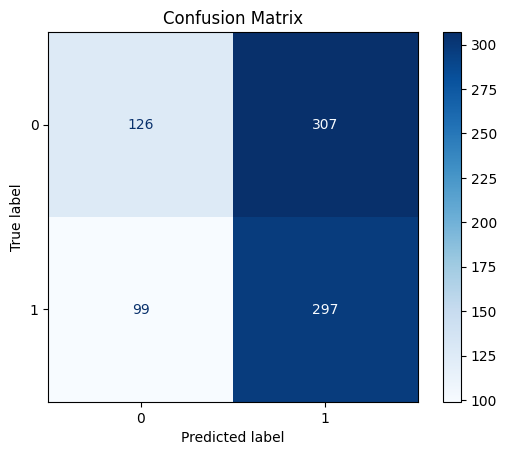

In [74]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()


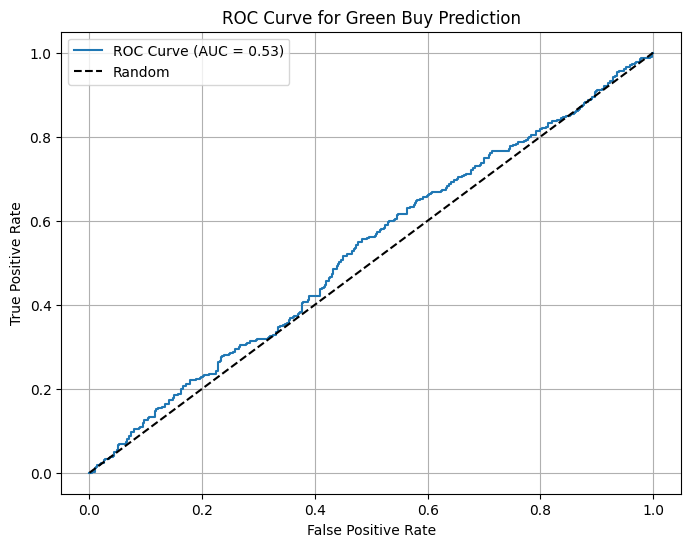

In [75]:
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test)[:, 1]  # Prob of True
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Green Buy Prediction')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Avg Precision = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()


<div style='font-size: 40px;'><u>EDA</u></div>
<div style='font-size: 20px;'>- want to see relationship bt max dip and return percentage</div>
<div style='font-size: 20px;'>- look into overnight positions</div>
<div style='font-size: 20px;'>- look into volume</div>

In [ ]:
eda = focus.copy()
eda

In [ ]:
eda['3p slope'] = [(eda.iloc[i]['close'] - eda.iloc[i-3]['close'])/3 for i in range(len(eda))]
eda['5p slope'] = [(eda.iloc[i]['close'] - eda.iloc[i-5]['close'])/5 for i in range(len(eda))]
eda['10p slope'] = [(eda.iloc[i]['close'] - eda.iloc[i-10]['close'])/10 for i in range(len(eda))]
eda['time'] = [eda.index[i].time() for i in range(len(eda))]

In [ ]:
eda['ordinal time'] = [eda.iloc[i]['time'].hour for i in range(len(eda))]

In [ ]:
green_buys = eda[eda['green_buy']==True]

fig1 = px.histogram(green_buys,x='ordinal time',nbins=20)
#fig2 = px.histogram(green_buys,x='5p slope')
#fig3 = px.histogram(green_buys,x='10p slope')

fig1.show()
#fig2.show()
#fig3.show()

<div style='font-size: 20px;'>optimizing n-period mean length</div>

In [ ]:
#START AND END TIME
########################
length = 60
start_time = datetime.now() - timedelta(days=length)
#end_time = '2024-03-25'

In [ ]:
optimize_df = pd.DataFrame(columns=['N-period-mean', 'Growth','Accuracy'])
counter = 0
for n in np.arange(5,51,5):
    hist, focus, signals = load_stock('BB', start_time, interval_type = TimeFrameUnit.Minute, interval_length = 1, mean_period = n)
    growth, growth_vals, focus = simulate(focus, signals)

    correct_percentage =  sum(growth_vals>=1)/len(growth_vals)
    #new_row = {'N-period-mean':n,'Growth':growth,'Accuracy':correct_percentage}
    new_row = [n,growth,correct_percentage]
    optimize_df.loc[counter] = new_row
    counter+=1

optimize_df

    

In [ ]:
from plotly.subplots import make_subplots

optimize_plot = make_subplots(rows=3, cols=1, shared_xaxes=True)

optimize_plot.add_trace(go.Scatter(x=optimize_df['N-period-mean'], y=optimize_df['Growth'], mode='lines+markers', name='growth', line=dict(color='green')),row=1,col=1)
optimize_plot.add_trace(go.Scatter(x=optimize_df['N-period-mean'], y=optimize_df['Accuracy'], mode='lines+markers', name='acc', line=dict(color='red')),row=2,col=1)
optimize_plot.add_trace(go.Scatter(x=optimize_df['N-period-mean'], y=optimize_df['Growth']*optimize_df['Accuracy'], mode='lines+markers', name='growth x acc', line=dict(color='teal')),row=3,col=1)
